## Train experiments with an autoencoder as DR

Train an autoencoder with swapping loss

In [1]:
%load_ext autoreload
%autoreload 2

## Initialization

Imports

In [2]:
import sys
sys.path.append('../')

import matplotlib.pyplot as plt

# local imports
from setup import setup_device, setup_datamodule, load_model
from dimensionality_reduction.feature_autoencoder import FeatureAutoencoder



Please cite the following paper when using nnUNet:

Isensee, F., Jaeger, P.F., Kohl, S.A.A. et al. "nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation." Nat Methods (2020). https://doi.org/10.1038/s41592-020-01008-z


If you have questions or suggestions, feel free to open an issue at https://github.com/MIC-DKFZ/nnUNet

nnUNet_raw_data_base is not defined and nnU-Net can only be used on data for which preprocessed files are already present on your system. nnU-Net cannot be used for experiment planning and preprocessing like this. If this is not intended, please read documentation/setting_up_paths.md for information on how to set this up properly.
nnUNet_preprocessed is not defined and nnU-Net can not be used for preprocessing or training. If this is not intended, please read documentation/setting_up_paths.md for information on how to set this up.
RESULTS_FOLDER is not defined and nnU-Net cannot be used for training or inference. If this is not in

Set the device globally

In [3]:
device = setup_device('cuda:2')
print(device, type(device))

cuda:2 <class 'torch.device'>


Load a trained model

In [4]:
model = load_model('../pre-trained/trained_UNets/mnmv2-00-02_22-11-2024-v1.ckpt', device)

Loaded as Lightning module


Initialize mnmv2 dataset module

In [5]:
datamodule = setup_datamodule()

### Preparation

Take the first batch from the datamodule

In [6]:
data_batch = next(iter(datamodule.val_dataloader()))

data_sample = data_batch['input']
data_sample.size() # [batch size, channels, width, hegiht]

torch.Size([32, 1, 256, 256])

In [7]:
# selected_layer_names = [
#   # 'model.model.1.submodule.0.conv.unit0.adn.A',
#   'model.model.1.submodule.0.conv.unit1.adn.A',
#   'model.model.1.submodule.0.conv.unit2.adn.A',
#   # 'model.model.1.submodule.1.submodule.0.conv',
#   'model.model.1.submodule.0.conv.unit3.adn.A',
#   'model.model.1.submodule.1.submodule.2.1.conv'
#   ]

selected_layer_names = [
  'model.model.1.submodule.0.conv.unit0.adn.A',
  # 'model.model.1.submodule.0.conv.unit1.adn.A',
  'model.model.1.submodule.0.conv.unit2.adn.A',
  # 'model.model.1.submodule.1.submodule.0.conv',
  'model.model.1.submodule.0.conv.unit3.adn.A',
  'model.model.1.submodule.1.submodule.2.1.conv'
  ]

Define visualization functions:

In [8]:
def visualize(image):
    if image.shape[0] > 3:  # If more than 3 channels, average channels
        # return image.mean(axis=0)
        return image[0]
    else:  # If 3 or fewer channels, just transpose to match image format
        return image.transpose(1, 2, 0)  # [C, H, W] -> [H, W, C]

In [9]:
def plot_results(orig, reconstr, latent):
    # Create a side-by-side plot
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    # Original Image
    axes[0].imshow(visualize(orig), cmap='gray')
    axes[0].set_title("Original Image")
    axes[0].axis("off")

    # Reconstructed Image
    axes[1].imshow(visualize(reconstr), cmap='gray')
    axes[1].set_title("Reconstructed Image")
    axes[1].axis("off")

    # Latent Representation (3 channels, like RGB)
    axes[2].imshow(latent.transpose(1, 2, 0))  # Transpose for [H, W, C]
    axes[2].set_title("Latent Representation")
    axes[2].axis("off")

    plt.tight_layout()
    plt.show()

torch.Size([1, 256, 256])


(np.float64(-0.5), np.float64(255.5), np.float64(255.5), np.float64(-0.5))

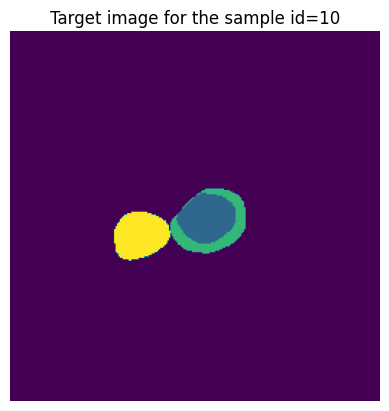

In [10]:
SAMPLE_ID = 10

data_sample_target = data_batch['target'][SAMPLE_ID]
print(data_sample_target.size())

plt.imshow(data_sample_target.detach().numpy().transpose(1, 2, 0))
plt.title(f'Target image for the sample id={SAMPLE_ID}')
plt.axis("off")

## Whole Dataset Training

In [11]:
# model train params
EPOCHS_COUNT = 15
LEARNING_RATE = 1e-3

# output dims of dim reduction
OUT_DIMS = 3

# INPUT CHANNELS
C = 32

BATCH_SIZE = 32

ALPHA = .8 # image loss weight
BETA = .4 # model loss weight

### Train new autoencoder

In [12]:
from dimensionality_reduction.train import modified_train_dr

In [ ]:
autoencoder = FeatureAutoencoder(C, OUT_DIMS)

defined an autoencoder with input channels=32 and out channels=3


In [14]:
import wandb

# Initialize wandb
wandb.init(project="modified-autoencoder-training", config={
    "learning_rate": LEARNING_RATE, "epochs": EPOCHS_COUNT,
    "batch_size": BATCH_SIZE, "image_loss_weight": ALPHA,
    "model_loss_weight": BETA
    })

wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: vaklr (vaklr-bonn). Use `wandb login --relogin` to force relogin


In [15]:
# Track model parameters
wandb.watch(autoencoder, log="all", log_freq=10)

In [16]:
modified_train_dr(autoencoder=autoencoder, datamodule=datamodule,
                                model=model, device=device,
                                logger=wandb.log,
                                selected_layer_names=selected_layer_names,
                                num_epochs=EPOCHS_COUNT, learning_rate=LEARNING_RATE,
                                alpha=ALPHA, beta=BETA)

Epoch [1/15], Loss: 64.6898
Epoch [2/15], Loss: 45.0494
Epoch [3/15], Loss: 30.6937
Epoch [4/15], Loss: 25.9077
Epoch [5/15], Loss: 23.0747
Epoch [6/15], Loss: 20.5829
Epoch [7/15], Loss: 18.5956
Epoch [8/15], Loss: 17.1190
Epoch [9/15], Loss: 15.8423
Epoch [10/15], Loss: 14.8204
Epoch [11/15], Loss: 14.0465
Epoch [12/15], Loss: 13.3935
Epoch [13/15], Loss: 12.7222
Epoch [14/15], Loss: 12.2460
Epoch [15/15], Loss: 11.7780


FeatureAutoencoder(
  (encoder): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): Conv2d(32, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (decoder): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
)

In [17]:
# Finish wandb run
wandb.finish()

batch_image_loss,▇▇█▇▅▄▅▅▅▅▅▆▅▆▄▅▄▃▃▃▃▃▃▃▃▂▃▂▂▂▃▂▂▃▂▂▂▂▁▁
batch_model_loss,█▆▆▆▅▅▅▅▄▅▄▄▄▃▃▃▃▂▂▂▂▂▁▁▂▁▁▂▁▁▂▁▁▁▂▁▁▁▂▁
batch_train_loss,█▄▅▄▄▃▃▂▂▂▂▂▁▂▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch_loss,█▅▄▃▂▂▂▂▂▁▁▁▁▁▁
batch_image_loss,0.21348
batch_model_loss,0.16698
batch_train_loss,18.23539
epoch_loss,11.77802


### Display results

In [18]:
from adapters.main import capture_convolution_layers

wrapper, layer_names = capture_convolution_layers(model, device, data_sample)
layer_samples = wrapper.layer_activations[selected_layer_names[2]]

In [19]:
selected_sample = layer_samples[SAMPLE_ID]
original_np = selected_sample.detach().numpy()

In [20]:
latent, reconstructed = autoencoder(selected_sample)
latent_np = latent.detach().numpy()
reconstructed_np = reconstructed.detach().numpy()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-5.5628066..6.148915].


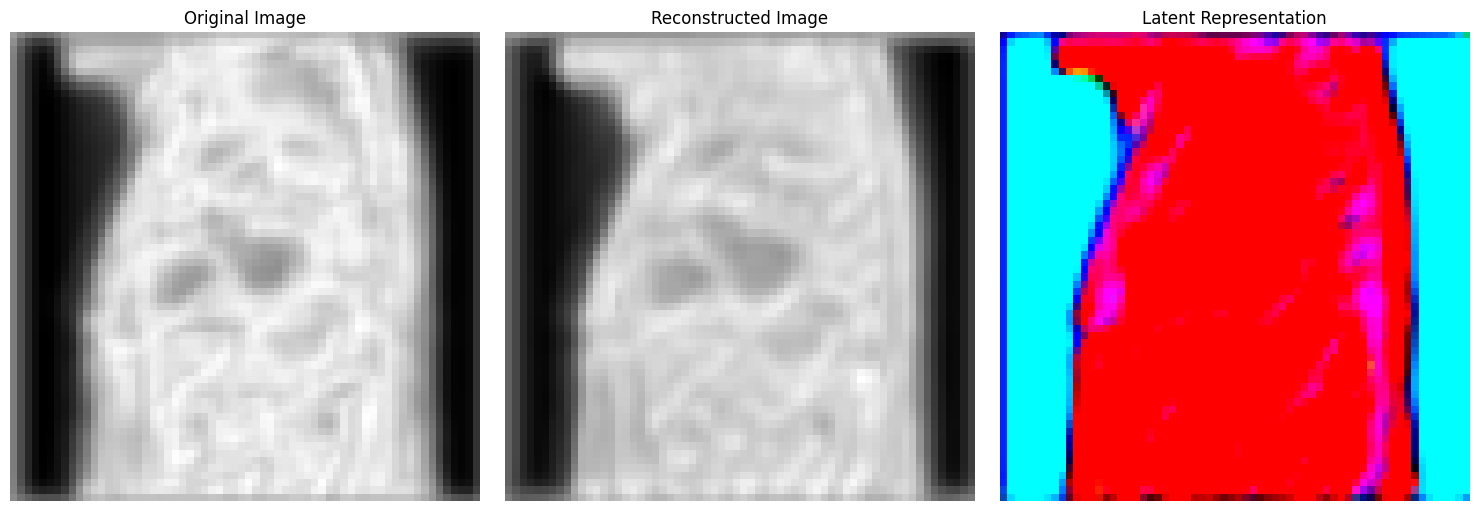

In [21]:
plot_results(original_np, reconstructed_np, latent_np)

In [22]:
import numpy as np

mse_error = np.mean((original_np - reconstructed_np) ** 2)

print(f"MSE Error: {mse_error.item()}")

MSE Error: 0.10834045708179474


Let's examine MSEs of some samples from different layers...

1. one of the trained layers:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-4.6573787..7.871109].


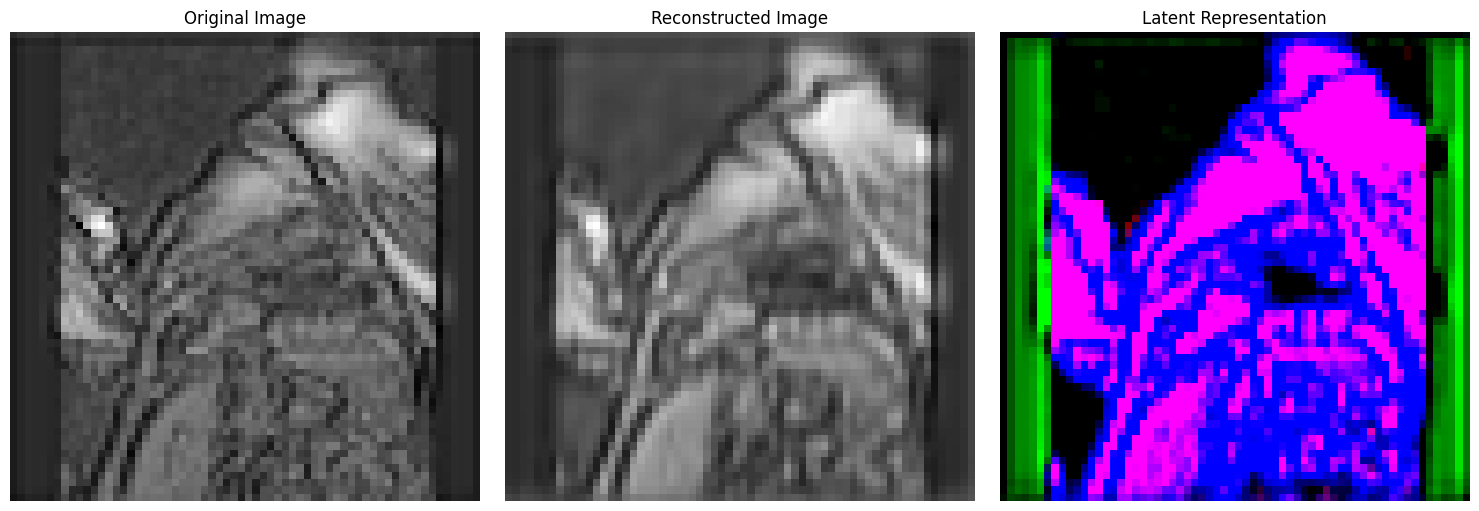

MSE Error: 0.1825939267873764


In [30]:
layer_samples_new = wrapper.layer_activations['model.model.1.submodule.0.conv.unit0.adn.A']
selected_sample_new = layer_samples_new[13]
original_np_new = selected_sample_new.detach().numpy()
latent_new, reconstructed_new = autoencoder(selected_sample_new)
latent_np_new = latent_new.detach().numpy()
reconstructed_np_new = reconstructed_new.detach().numpy()
plot_results(original_np_new, reconstructed_np_new, latent_np_new)
mse_error_new = np.mean((original_np_new - reconstructed_np_new) ** 2)
print(f"MSE Error: {mse_error_new.item()}")

2. from the one we haven't trained on:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.6544166..3.0260348].


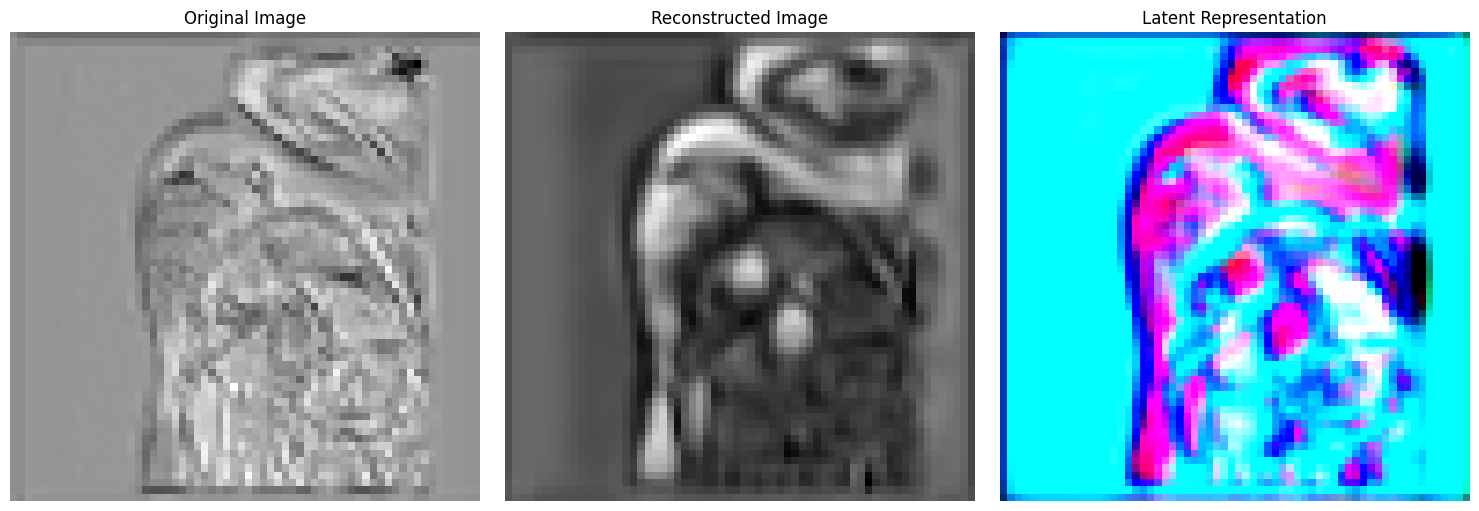

MSE Error: 0.5246063470840454


In [23]:
layer_samples_new = wrapper.layer_activations['model.model.1.submodule.1.submodule.0.conv']
selected_sample_new = layer_samples_new[30]
original_np_new = selected_sample_new.detach().numpy()
latent_new, reconstructed_new = autoencoder(selected_sample_new)
latent_np_new = latent_new.detach().numpy()
reconstructed_np_new = reconstructed_new.detach().numpy()
plot_results(original_np_new, reconstructed_np_new, latent_np_new)
mse_error_new = np.mean((original_np_new - reconstructed_np_new) ** 2)
print(f"MSE Error: {mse_error_new.item()}")

### Save trained autoencoder

In [31]:
FILE_NAME = 'modified_encoder_e15_balanced'

In [32]:
from model_saver import ModelSaver

saver = ModelSaver('./modified_autoencoders')

saver.save_model_config(autoencoder, file_name=FILE_NAME)

Model saved to ./modified_autoencoders/modified_encoder_e15_balanced.pth


### Load saved autoencoder

In [38]:
# Initialize the same autoencoder structure
autoencoder_saved = FeatureAutoencoder(C, OUT_DIMS)
saver.load_autoencoder_config(autoencoder_saved, FILE_NAME)

defined an autoencoder with input channels=16 and out channels=3
Autoencoder loaded successfully


/home/keller/repos/MedImSeg-Lab24/src/dimensionality_reduction/../dimensionality_reduction/save_utils.py:19: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  autoencoder.load_s